In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
# from imblearn.under_sampling import RandomUnderSampler
# import cufflinks as cf
import researchpy as rp
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import statsmodels.api as sm
import pingouin as pg
from statsmodels.compat import lzip
from pingouin import pairwise_gameshowell, pairwise_tukey, pairwise_corr
sns.set(context='notebook', style='whitegrid', palette='Set2', font='sans-serif',
       font_scale=1.2, color_codes=True, rc={'figure.figsize':(20.7,20.27)})
%matplotlib inline

/home/kpoloni/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
adni = pd.read_csv('dataset/ADNI_all_images.csv')
adni = adni[['Subject ID', 'Research Group', 'Image Filename', 'MMSE Total Score']]
adni['Image Filename'] = adni['Image Filename'].apply(lambda x: x.split(".nii")[0])

In [3]:
cn = pd.read_csv('predict_results/test_exp_LR.csv', sep=',')
cn['Research Group'] = 'CN'
ad = pd.read_csv('predict_results/ad_images_LR.csv', sep=',')
ad['Research Group'] = 'AD'
mci= pd.read_csv('predict_results/mci_images_LR.csv', sep=',')
mci['Research Group'] = 'MCI'
results = pd.concat([cn, ad, mci]).reset_index(drop=True)
results = results[['Name', 'True', 'Pred', 'Research Group']]
results.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']
results.head()

,Image Filename,Chronological age,Estimated age,Research Group
0,023_S_4164_ADNI2_Month_6-New_Pt,73.6,76.217193,CN
1,014_S_4093_ADNI2_Month_6-New_Pt,70.6,81.623898,CN
2,021_S_0647_ADNI_Screening,72.9,81.181915,CN
3,123_S_0298_ADNI_Screening,76.6,77.335740,CN
4,022_S_4320_ADNI2_Month_6-New_Pt,71.5,75.390853,CN


In [4]:
data = adni.merge(results, on=['Image Filename', 'Research Group']).reset_index(drop=True)
data.columns = ['Subject ID', 'group', 'Image Filename', 'MMSE', 'Chronological age', 'Estimated age']
data['Delta'] = data[['Chronological age', 'Estimated age']].apply(lambda x: x['Estimated age'] - x['Chronological age'], axis=1)
data.head()

,Subject ID,group,Image Filename,MMSE,Chronological age,Estimated age,Delta
0,035_S_0555,CN,035_S_0555_ADNI1GO_Month_6,30.0,77.7,80.460810,2.760810
1,013_S_0502,CN,013_S_0502_ADNI_Screening,29.0,75.1,71.834617,-3.265383
2,031_S_4032,CN,031_S_4032_ADNI2_Month_6-New_Pt,29.0,70.9,71.768250,0.868250
3,100_S_0035,CN,100_S_0035_ADNI_Screening,30.0,77.0,73.686615,-3.313385
4,129_S_4396,CN,129_S_4396_ADNI2_Year_1_Visit,29.0,79.5,73.095785,-6.404215


In [5]:
rp.summary_cont(data.groupby(['group']))['Delta']

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
AD,209,3.3581,4.7648,0.3296,2.7083,4.0078
CN,151,-0.2395,4.3769,0.3562,-0.9433,0.4643
MCI,251,2.5212,5.0856,0.3210,1.8890,3.1534


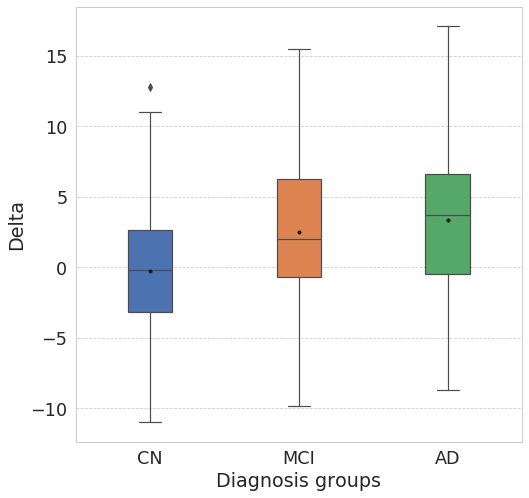

In [6]:
fig= plt.figure(figsize=(8,8))
sns.set(context='paper', 
#         palette='muted', 
        font='sans-serif',
       font_scale=2.0, color_codes=True)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

dt = data[['Delta', 'group']]
dt.columns = ['Delta', 'Diagnosis groups']
sns.boxplot(x="Diagnosis groups", y="Delta", order=['CN', 'MCI', 'AD'],
            showmeans=True, 
            saturation=1.5,
            meanprops={"marker":"o",
                       "markersize":3,
                       "markerfacecolor":"k",
                       "markeredgecolor":"k"
                      },  
                       data=dt, width=0.3)
# plt.savefig("groups_boxplot_var.pdf", bbox_inches='tight')

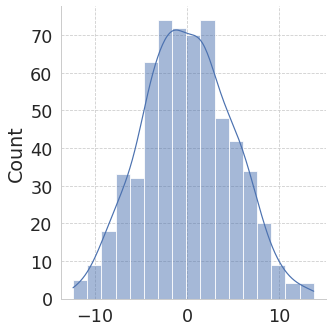

In [7]:
# Get model residuals
slr_results1 = ols('Delta ~ C(group)', data=data).fit()
sns.displot(slr_results1.resid, kde=True)

In [8]:
# Test ANOVA conditions
# Shapiro: h0:  normal distribution.
alpha = 0.01
_, p_value = stats.shapiro(slr_results1.resid)
print(p_value, "Normal" if p_value>alpha else "Not normal")
# Equal variance
homs = pg.homoscedasticity(data, dv='Delta', group='group', method="levene", alpha=alpha)
print(homs.pval[0], "Equal var" if homs.equal_var[0] > alpha else "Not equal var")

0.34546610713005066 Normal
0.10507366799497 Equal var


In [9]:
slr_results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Delta   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     25.97
Date:                Mon, 19 Apr 2021   Prob (F-statistic):           1.50e-11
Time:                        13:41:32   Log-Likelihood:                -1825.1
No. Observations:                 611   AIC:                             3656.
Df Residuals:                     608   BIC:                             3669.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.3581      0.333     10.095      0.000       2.705       4.011
C(group)[T.CN]     -3.5975      0.514     -7.004      0.000      -4.606      -2.589
C(group)[T.MCI]    -0.8369      0.450     -1.858      0.064      -1.721       0.047
==============================================================================
Omnibus:                        3.814   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                3.105
Skew:                           0.064   Prob(JB):                        0.212
Kurtosis:                       2.675   Cond. No.                         3.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
pg.anova(data=data, dv='Delta', between='group', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,group,1201.369244,2,600.684622,25.972506,1.500831e-11,0.078711
1,Within,14061.648566,608,23.127711,NaN,NaN,NaN


In [11]:
pairwise_tukey(data=data, dv='Delta', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,AD,CN,3.358089,-0.239458,3.597546,0.513637,7.004069,0.001000,0.746498
1,AD,MCI,3.358089,2.521164,0.836924,0.450335,1.858450,0.151949,0.173743
2,CN,MCI,-0.239458,2.521164,-2.760622,0.495284,-5.573820,0.001000,-0.572961


In [12]:
pg.pairwise_ttests(dv='Delta', between='group', data=data, alpha=0.01, effsize='hedges', padjust='bonferroni')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,group,AD,CN,False,True,7.413306,338.087134,two-sided,9.980907e-13,2.994272e-12,bonferroni,7.351e+09,0.779377
1,group,AD,MCI,False,True,1.819112,451.647381,two-sided,6.955636e-02,2.086691e-01,bonferroni,0.515,0.169056
2,group,CN,MCI,False,True,-5.757397,352.917058,two-sided,1.858069e-08,5.574206e-08,bonferroni,5.884e+05,-0.570245


Multiple Comparison of Means - Tukey HSD, FWER=0.01 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    AD     CN  -3.5975  0.001 -5.0997 -2.0954   True
    AD    MCI  -0.8369 0.1519 -2.1539  0.4801  False
    CN    MCI   2.7606  0.001  1.3122  4.2091   True
----------------------------------------------------


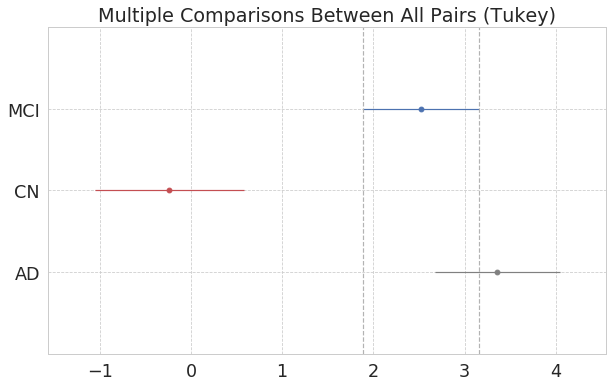

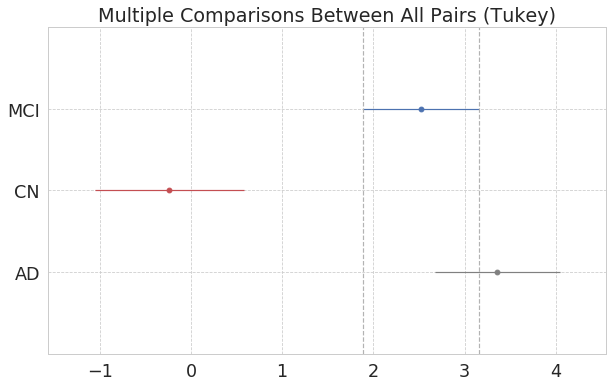

In [13]:
# Tukey’s HSD Post-hoc comparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(data['Delta'], data['group'])
mc_results = mc.tukeyhsd(alpha=0.01)
print(mc_results.summary())
mc_results.plot_simultaneous(comparison_name="MCI")

# Preciso transformar

In [9]:
from sklearn.preprocessing import PowerTransformer
dt = data.Delta + 1 - data.Delta.min()
pt = PowerTransformer(method='box-cox', standardize=True)
pt.fit(dt[:,np.newaxis])
dt3 = pt.transform(dt[:,np.newaxis])
data['Delta2'] = dt3
print(pt.lambdas_)
# Shapiro: h0:  normal distribution.
alpha = 0.01
_, p_value = stats.shapiro(slr_results.resid)
print(p_value, "Normal" if p_value>alpha else "Not normal")
# Equal variance
homs = pg.homoscedasticity(data, dv='Delta2', group='group', method="levene", alpha=alpha)
print(homs.pval[0], "Equal var" if homs.equal_var[0] > alpha else "Not equal var")

[0.88293017]


NameError: name 'slr_results' is not defined

In [226]:
dt = data.Delta
pt = PowerTransformer(method='yeo-johnson', standardize=True)
pt.fit(dt[:,np.newaxis])
dt3 = pt.transform(dt[:,np.newaxis])
data['Delta2'] = dt3
print(pt.lambdas_)
# Shapiro: h0:  normal distribution.
alpha = 0.01
_, p_value = stats.shapiro(slr_results.resid)
print(p_value, "Normal" if p_value>alpha else "Not normal")
# Equal variance
homs = pg.homoscedasticity(data, dv='Delta2', group='group', method="levene", alpha=alpha)
print(homs.pval[0], "Equal var" if homs.equal_var[0] > alpha else "Not equal var")

[0.98181992]
0.42844605445861816 Normal
4.941054047441378e-05 Not equal var


In [227]:
dt = data.Delta + 1 - data.Delta.min()
data['Delta2'] = np.log(dt)
# Shapiro: h0:  normal distribution.
alpha = 0.01
_, p_value = stats.shapiro(slr_results.resid)
print(p_value, "Normal" if p_value>alpha else "Not normal")
# Equal variance
homs = pg.homoscedasticity(data, dv='Delta2', group='group', method="levene", alpha=alpha)
print(homs.pval[0], "Equal var" if homs.equal_var[0] > alpha else "Not equal var")

0.42844605445861816 Normal
0.03837796114023689 Equal var


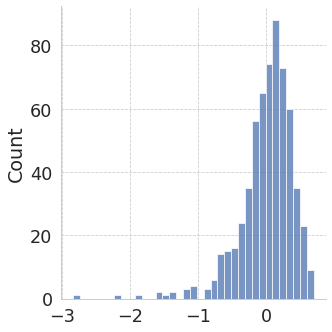

In [228]:
slr_results = ols('Delta2 ~ C(group)', data=data).fit()
sns.displot(slr_results.resid)

In [229]:
rp.summary_cont(data.groupby(['group']))['Delta2']

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
AD,209,2.8409,0.4197,0.0290,2.7837,2.8981
CN,151,2.6485,0.3228,0.0263,2.5966,2.7004
MCI,251,2.7721,0.4113,0.0260,2.7210,2.8232


In [68]:
# data

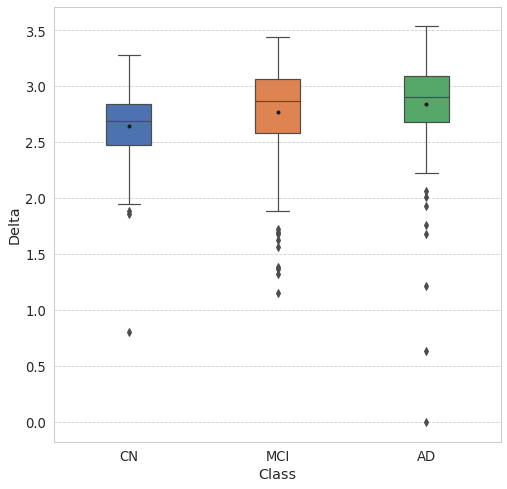

In [230]:
fig= plt.figure(figsize=(8,8))
sns.set(context='paper', 
#         palette='muted', 
        font='sans-serif',
       font_scale=1.5, color_codes=True)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

dt = data[['Delta2', 'group']]
dt.columns = ['Delta', 'Class']
sns.boxplot(x="Class", y="Delta", order=['CN', 'MCI', 'AD'],
            showmeans=True, 
            saturation=1.5,
            meanprops={"marker":"o",
                       "markersize":3,
                       "markerfacecolor":"k",
                       "markeredgecolor":"k"
                      },  
                       data=dt, width=0.3)
# plt.savefig("groups_boxplot_skewness.pdf", bbox_inches='tight')

# plt.legend(loc='upper right', fontsize='small')

In [231]:
slr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Delta2   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     10.51
Date:                Tue, 06 Apr 2021   Prob (F-statistic):           3.27e-05
Time:                        14:44:52   Log-Likelihood:                -296.90
No. Observations:                 611   AIC:                             599.8
Df Residuals:                     608   BIC:                             613.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8409      0.027    104.151      0.000       2.787       2.894
C(group)[T.CN]     -0.1924      0.042     -4.569      0.000      -0.275      -0.110
C(group)[T.MCI]    -0.0688      0.037     -1.863      0.063      -0.141       0.004
==============================================================================
Omnibus:                      274.465   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1783.607
Skew:                          -1.886   Prob(JB):                         0.00
Kurtosis:                      10.472   Cond. No.                         3.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [233]:
# Check if tukey's
_, p_value = stats.levene(data['Delta2'][data['group']=='AD'],
                          data['Delta2'][data['group']=='CN'],
                          data['Delta2'][data['group']=='MCI'])

print(p_value, "Equal Var" if p_value>alpha else "Not equal")

0.03837796114023689 Equal Var


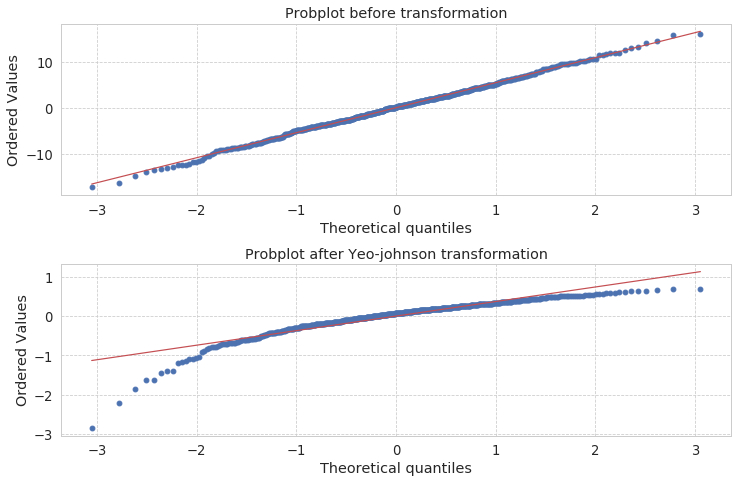

In [234]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax1 = fig.add_subplot(311)
prob = stats.probplot(slr_results1.resid, dist=stats.norm, plot=ax1)
ax1.set_title('Probplot before transformation')

ax2 = fig.add_subplot(312)
prob = stats.probplot(slr_results.resid, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Yeo-johnson transformation')
# plt.savefig("probplot_skewnwss.pdf", bbox_inches='tight')
plt.show()

In [235]:
v = rp.summary_cont(data.groupby(['group']))['Delta2']
v

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
AD,209,2.8409,0.4197,0.0290,2.7837,2.8981
CN,151,2.6485,0.3228,0.0263,2.5966,2.7004
MCI,251,2.7721,0.4113,0.0260,2.7210,2.8232


# Todos requisitos atendidos

In [237]:
slr_results = ols('Delta2 ~ group', data=data).fit()
slr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Delta2   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     10.51
Date:                Tue, 06 Apr 2021   Prob (F-statistic):           3.27e-05
Time:                        14:45:37   Log-Likelihood:                -296.90
No. Observations:                 611   AIC:                             599.8
Df Residuals:                     608   BIC:                             613.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8409      0.027    104.151      0.000       2.787       2.894
group[T.CN]     -0.1924      0.042     -4.569      0.000      -0.275      -0.110
group[T.MCI]    -0.0688      0.037     -1.863      0.063      -0.141       0.004
==============================================================================
Omnibus:                      274.465   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1783.607
Skew:                          -1.886   Prob(JB):                         0.00
Kurtosis:                      10.472   Cond. No.                         3.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [238]:
aov_table = sms.anova_lm(slr_results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,3.267346,2.0,10.505908,0.000033
Residual,94.544259,608.0,NaN,NaN


In [239]:
# aov = pg.mixed_anova(dv='AI2', within='gender', between='group', subject='subject', data=data)
# aov
pg.anova(data=data, dv='Delta2', between='group', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.267346,2,1.633673,10.505908,0.000033,0.033404
1,Within,94.544259,608,0.155500,NaN,NaN,NaN


In [240]:
tt = pg.pairwise_ttests(dv='Delta2', between='group', data=data, alpha=0.01, effsize='hedges', padjust='bonferroni')
# pg.print_table(tt, floatfmt='.3f')
tt

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,group,AD,CN,False,True,4.915518,356.580720,two-sided,0.000001,0.000004,bonferroni,9639.945,0.502603
1,group,AD,MCI,False,True,1.766177,439.713470,two-sided,0.078060,0.234180,bonferroni,0.47,0.165423
2,group,CN,MCI,False,True,-3.348484,372.760033,two-sided,0.000895,0.002686,bonferroni,23.865,-0.324376


In [241]:
tk = pairwise_tukey(data=data, dv='Delta2', between='group')
tk

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,AD,CN,2.840896,2.648462,0.192434,0.042117,4.569064,0.001000,0.486974
1,AD,MCI,2.840896,2.772116,0.068781,0.036926,1.862654,0.150663,0.174136
2,CN,MCI,2.648462,2.772116,-0.123654,0.040612,-3.044763,0.006856,-0.312986


## Conclusao:<br>
- p-value: 8.25e-09<br>
- F-stats: 19.08<br>
Portanto, pelo menos uma das médias difere

# Tukey-Kramer test

Multiple Comparison of Means - Tukey HSD, FWER=0.01 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    AD     CN  -0.1924  0.001 -0.3156 -0.0693   True
    AD    MCI  -0.0688 0.1507 -0.1768  0.0392  False
    CN    MCI   0.1237 0.0069  0.0049  0.2424   True
----------------------------------------------------


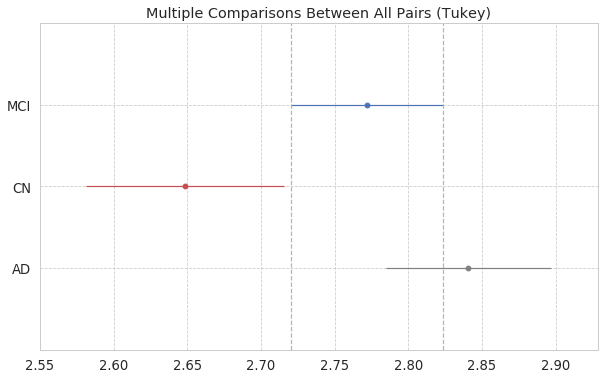

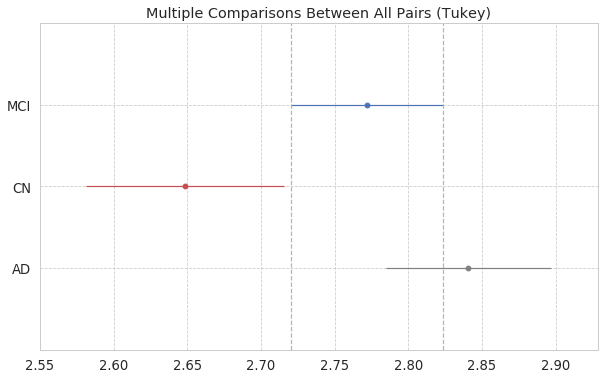

In [242]:
# Tukey’s HSD Post-hoc comparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(data['Delta2'], data['group'])
mc_results = mc.tukeyhsd(alpha=0.01)
print(mc_results.summary())
mc_results.plot_simultaneous(comparison_name="MCI")
# mc_results.halfwidths

In [243]:
def anova_table2(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [244]:
def anova_table(aov):
    SSb, SSw = aov[:-1]['sum_sq'], aov['sum_sq'][-1]
    DFb, DFw = aov[:-1]['df'], aov['df'][-1]
    MSb, MSw = SSb/DFb, SSw/DFw
#     aov['mean_sq'] = MSb, MSw
    aov['eta_sq'] = SSb/(SSb+SSw)
    aov['omega_sq'] = (SSb-(DFb*MSw))/(SSb+SSw+MSw)
    cols = ['sum_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [245]:
aov_table = sms.anova_lm(slr_results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,3.267346,2.0,10.505908,0.000033
Residual,94.544259,608.0,NaN,NaN


In [246]:
anova_table2(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
group,3.267346,2.0,1.633673,10.505908,0.000033,0.033404,0.030177
Residual,94.544259,608.0,0.155500,NaN,NaN,NaN,NaN
